## Noisy, Parallel, Multi-Objective BO in BoTorch with qEHVI, qNEHVI, and qNParEGO

In this tutorial, we illustrate how to implement a simple multi-objective (MO) Bayesian Optimization (BO) closed loop in BoTorch.

In general, we recommend using [Ax](https://ax.dev) for a simple BO setup like this one, since this will simplify your setup (including the amount of code you need to write) considerably. See [here](https://ax.dev/tutorials/multiobjective_optimization.html) for an Ax tutorial on MOBO. If desired, you can use a custom BoTorch model in Ax, following the [Using BoTorch with Ax](./custom_botorch_model_in_ax) tutorial. Given a `MultiObjective`, Ax will default to the $q$NEHVI acquisiton function. If desired, this can also be customized by adding `"botorch_acqf_class": <desired_botorch_acquisition_function_class>,` to the `model_kwargs`.

We use the parallel ParEGO ($q$ParEGO) [1], parallel Expected Hypervolume Improvement ($q$EHVI) [1], and parallel Noisy Expected Hypervolume Improvement ($q$NEHVI) [2]  acquisition functions to optimize a synthetic BraninCurrin problem test function with additive Gaussian observation noise over a 2-parameter search space [0,1]^2. See  `botorch/test_functions/multi_objective.py` for details on BraninCurrin. The noise standard deviations are 15.19 and 0.63 for each objective, respectively.

Since botorch assumes a maximization of all objectives, we seek to find the Pareto frontier, the set of optimal trade-offs where improving one metric means deteriorating another.

[1] [S. Daulton, M. Balandat, and E. Bakshy. Differentiable Expected Hypervolume Improvement for Parallel Multi-Objective Bayesian Optimization. Advances in Neural Information Processing Systems 33, 2020.](https://arxiv.org/abs/2006.05078)

[2] [S. Daulton, M. Balandat, and E. Bakshy. Parallel Bayesian Optimization of Multiple Noisy Objectives with Expected Hypervolume Improvement. Advances in Neural Information Processing Systems 34, 2021.](https://arxiv.org/abs/2105.08195)

**For batch optimization (or in noisy settings), we strongly recommend using $q$NEHVI rather than $q$EHVI because it is far more efficient than $q$EHVI and mathematically equivalent in the noiseless setting.**

In [2]:
from typing import Dict, Optional, List, Union, Iterable, Sequence, Sized

from botorch.test_functions import Branin
from botorch.test_functions.base import MultiObjectiveTestProblem

from torch import Tensor
from torch.nn import Module

import plotly.graph_objects as go
import pandas as pd
import numpy as np
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning

In [3]:
# https://stackoverflow.com/questions/32791911/fast-calculation-of-pareto-front-in-python

# Faster than is_pareto_efficient_simple, but less readable.
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient

### Set dtype and device
Note: $q$EHVI and $q$NEHVI aggressively exploit parallel hardware and are both much faster when run on a GPU. See [1, 2] for details.

In [4]:
import os
import torch


tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
SMOKE_TEST = os.environ.get("SMOKE_TEST")

## 1d input example

In [5]:
def det_transform(y_0, X):
    return (-y_0 + 1 + 0.2*np.sin(30 * X[..., 0]) + 0.2)/1.4

class onedimexample(MultiObjectiveTestProblem):
    dim = 1
    num_objectives = 2
    _bounds = [(0.0, 1.0)]
    _ref_point = [2.0, 2.0]
    _max_hv = 3.5691902586474744  # this is approximated with N=10000 evaluation

    def __init__(self, noise_std: Optional[float] = None, negate: bool = False) -> None:
        super().__init__(noise_std=noise_std, negate=negate)

    def evaluate_true(self, X: Tensor) -> Tensor:
        y_0 = X[..., 0] * X[..., 0] * X[..., 0]
        y_1 = det_transform(y_0, X)
        return torch.stack([y_0, y_1], dim=-1)

In [6]:
problem = onedimexample(negate=True).to(**tkwargs)

In [7]:
# Read data from a csv
# z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')
N = 100
x = torch.linspace(0., 1., N).reshape(-1, 1)
# y = torch.linspace(0., 1., N)
# xy = torch.cartesian_prod(x, y)
z = problem(x)

In [8]:
a = is_pareto_efficient(-np.array(z), return_mask = True)

In [9]:
a.sum()

30

In [10]:
a

array([ True, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True])

In [11]:
Tensor([[0.7073],
        [0.3113],
        [0.1259],
        [0.8539],
        [0.8947],
        [0.0392],
        [0.4709],
        [0.6831],
        [0.9031]])

tensor([[0.7073],
        [0.3113],
        [0.1259],
        [0.8539],
        [0.8947],
        [0.0392],
        [0.4709],
        [0.6831],
        [0.9031]])

In [30]:

xs = Tensor([
#         [0.8947],
#         [0.0392],
#         [0.4709],
#         [0.6831],
#         [0.9031],
#         [0.2534],
#         [0.6834],
#         [0.8981],
#         [0.1028],
#         [0.8616],
[0.9954],
        [0.7894],
        [0.0000],
        [0.9588],
        [0.7582],
        [1.0000],
        [0.9757],
        [0.9422],
        [0.0759],
        [0.3678],
        [0.5812],
        [0.7722],
        [0.7455],
        [0.9337],
        [0.9505],
        [0.9670],
        [0.9848],
        [0.7960],
        [0.5525],
        [0.1549]
])
ys = problem(xs)

fig = go.Figure(data=[
#     go.Surface(z=z[:, 0].reshape(N, N), x=x, y=y),
    go.Scatter(y=z[:, 0], x=x[:, 0], mode='lines', name='f_0(x)'),
    go.Scatter(y=z[:, 1], x=x[:, 0], mode='lines', name='f_1(x)'),
    go.Scatter(y=torch.cat([z[a, 0], z[a, 1]], dim=0), 
               x=torch.cat([x[a, 0], x[a, 0]], dim=0), mode='markers', name='Pareto points'),
    go.Scatter(y=torch.cat([ys[:, 0], ys[:, 1]], dim=0), 
               x=torch.cat([xs[:, 0], xs[:, 0]], dim=0), 
               mode='markers+text', name='Points queried',
               text=2*list(range(1, 21)),
               textposition="top left"),
])
fig.update_layout(width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [33]:
fig = go.Figure(data=[
    go.Scatter(
        x=z[:,0], 
        y=z[:,1], 
        mode='markers',
        name='Pareto points'),
    go.Scatter(
        x=ys[:,0], 
        y=ys[:,1], 
        mode='markers+text', name='Points queried',
               text=2*list(range(1, 21)),
               textposition="top right")
])
fig.update_layout(
    width=500, height=500,
    xaxis_title="f_0(x)",
    yaxis_title="f_1(x)",
)
fig.show()

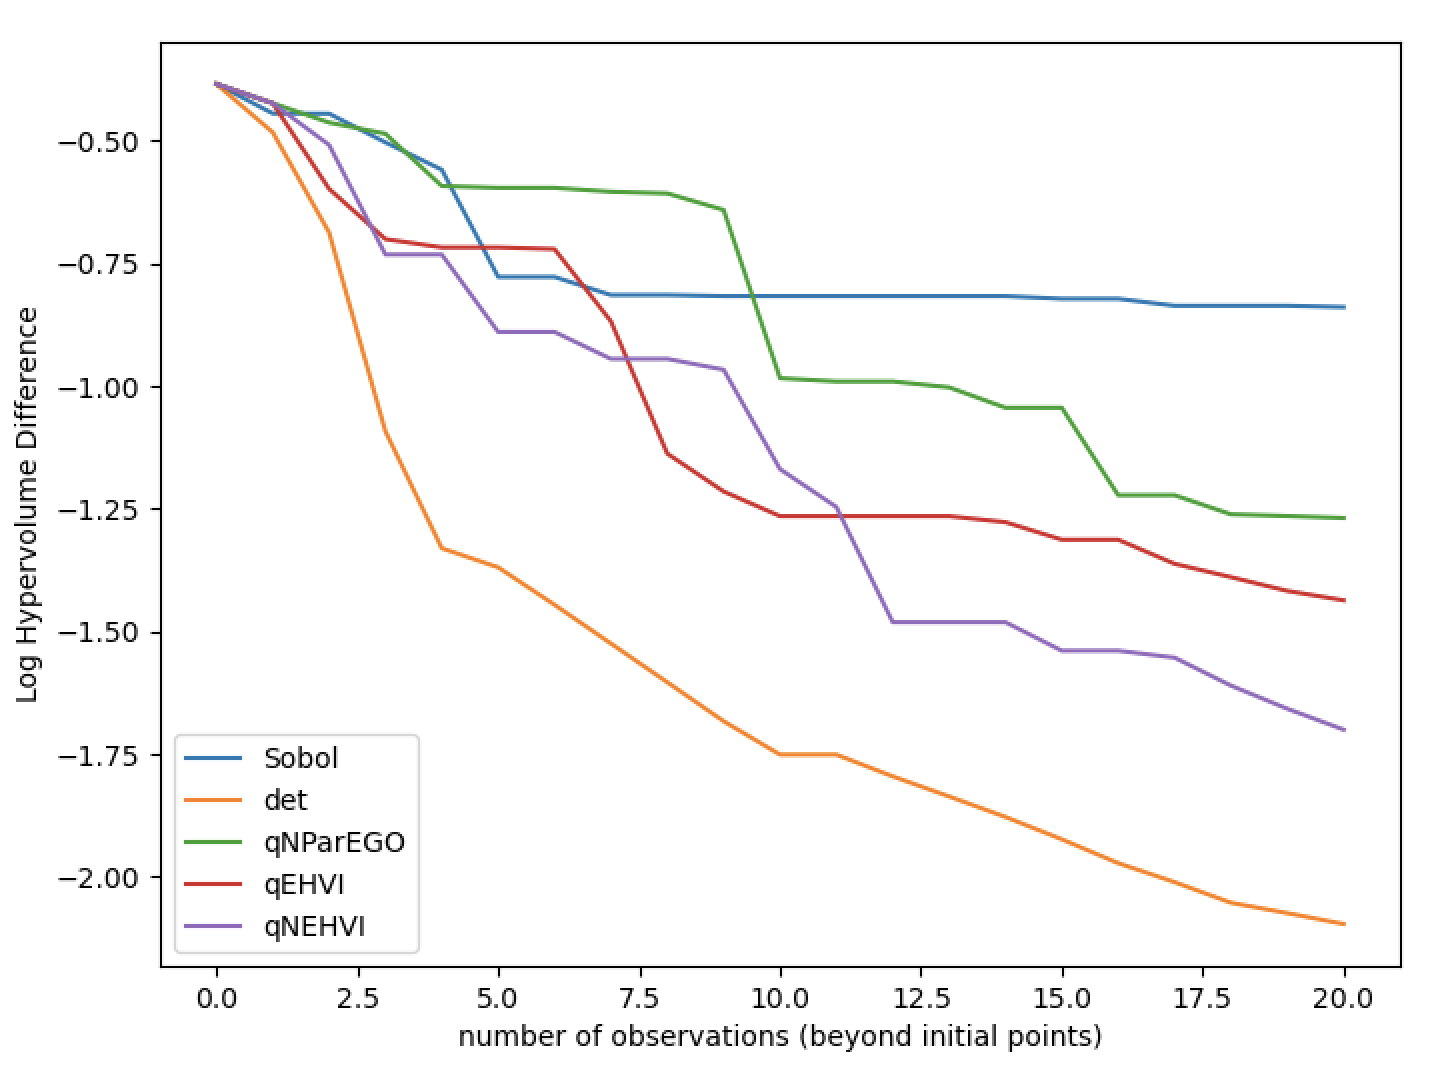

In [14]:
fig = go.Figure(data=[
    go.Scatter(
        x=z[a, 0], 
        y=z[a, 1], 
        mode='markers')
])
fig.update_layout(width=500, height=500,)
fig.show()

In [15]:
problem.ref_point

tensor([-2., -2.], dtype=torch.float64)

In [16]:
bd = DominatedPartitioning(ref_point=problem.ref_point, Y=z)
bd.compute_hypervolume().item()

NameError: name 'DominatedPartitioning' is not defined

## 2d input example

In [773]:
# from typing import Dict, Optional, List, Union, Iterable, Sequence, Sized

# from botorch.test_functions import Branin
# from botorch.test_functions.base import MultiObjectiveTestProblem

# from torch import Tensor
# from torch.nn import Module

# class BraninDeterministicallyTransformed(MultiObjectiveTestProblem):
#     r"""Two objective problem composed of the Branin and Currin functions.
#     """

#     dim = 2
#     num_objectives = 2
#     _bounds = [(0.0, 1.0), (0.0, 1.0)]
#     _ref_point = [18.0, 6.0]
#     # _max_hv = 59.36011874867746  # this is approximated using NSGA-II

#     def __init__(self, noise_std: Optional[float] = None, negate: bool = False) -> None:
#         r"""Constructor for Branin-Currin.

#         Args:
#             noise_std: Standard deviation of the observation noise.
#             negate: If True, negate the objectives.
#         """
#         super().__init__(noise_std=noise_std, negate=negate)
#         self._branin = Branin()

#     def _rescaled_branin(self, X: Tensor) -> Tensor:
#         # return to Branin bounds
# #         x_0 = 15 * X[..., 0] - 5
# #         x_1 = 15 * X[..., 1]
# #         y_0 = self._branin(torch.stack([x_0, x_1], dim=-1))
# # #         y_1 = y_0 * (np.sin(8. * np.pi * X[..., 1]) + 1.1)/2. * (np.cos(8. * np.pi * X[..., 0]) + 1.1)/2. 
# #         y_1 = y_0 * (X[..., 1]+1.) 
# #     (np.sin(2. * np.pi * X[..., 1]) + 1.2) * (np.cos(2. * np.pi * X[..., 0]) + 1.2)
# #         y_1 = -y_0 * (np.sin(4. * np.pi * X[..., 1]) + 1.1)/2. * (np.cos(4. * np.pi * X[..., 0]) + 1.1)/2. 
# #         y_1 = -y_0
#         y_0 = X[..., 0] * X[..., 0] * X[..., 0]
# #         y_1 = y_0 * (np.sin(8. * np.pi * X[..., 1]) + 1.1)/2. * (np.cos(8. * np.pi * X[..., 0]) + 1.1)/2. 
#         y_1 = -y_0 * (1/(X[..., 0]+0.5))
#         return torch.stack([y_0, y_1], dim=-1)

#     def evaluate_true(self, X: Tensor) -> Tensor:
#         return self._rescaled_branin(X=X)

### Problem setup


In [774]:
# from botorch.test_functions.multi_objective import BraninCurrin

# # problem = BraninCurrin(negate=True).to(**tkwargs)
# problem = BraninDeterministicallyTransformed(negate=True).to(**tkwargs)

### Plot the loss landscape

In [775]:
# import plotly.graph_objects as go
# import pandas as pd
# import numpy as np
# from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning

# # Read data from a csv
# # z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')
# N = 100
# x = torch.linspace(0., 1., N)
# y = torch.linspace(0., 1., N)
# xy = torch.cartesian_prod(x, y)
# z = problem(xy)

In [776]:
# partitioning = FastNondominatedPartitioning(
#         ref_point=Tensor([-600., -600.]), 
#         Y=z,
#     )
# pareto_Y = partitioning.pareto_Y

In [777]:
# pareto_Y.ge

In [778]:
# a = is_pareto_efficient(-np.array(z), return_mask = True)

In [779]:
# a.sum()

In [780]:
# fig = go.Figure(data=[
#     go.Surface(z=z[:, 0].reshape(N, N), x=x, y=y),
#     go.Scatter3d(z=np.zeros_like(pareto_Y[:,0]), 
#                  x=xy[a, 1], 
#                  y=xy[a, 0], mode='markers')
# ])
# fig.update_layout(width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90))
# fig.show()

In [781]:
# fig = go.Figure(data=[
#     go.Surface(z=z[:, 1].reshape(N, N), x=x, y=y),
#     go.Scatter3d(z=np.zeros_like(pareto_Y[:,0]), x=xy[a, 1], y=xy[a, 0], mode='markers')
# ])
# fig.update_layout(width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90))
# fig.show()

In [782]:
# fig = go.Figure(data=[
#     go.Scatter(
#         x=z[a, 0], 
#         y=z[a, 1], 
#         mode='markers')
# ])
# fig.update_layout(width=500, height=500,)
# fig.show()

#### Model initialization

We use a list of `FixedNoiseGP`s to model the two objectives with known noise variances. Homoskedastic noise levels can be inferred by using `SingleTaskGP`s instead of `FixedNoiseGP`s.

The models are initialized with $2(d+1)=6$ points drawn randomly from $[0,1]^2$.

In [783]:
from botorch.models.gp_regression import FixedNoiseGP, SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.utils.transforms import unnormalize, normalize
from botorch.utils.sampling import draw_sobol_samples

# NOISE_SE = torch.tensor([15.19, 0.63], **tkwargs)

def generate_initial_data(n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds,n=n, q=1).squeeze(1)
    train_obj_true = problem(train_x)
    train_obj = train_obj_true + torch.randn_like(train_obj_true) * NOISE_SE
    return train_x, train_obj, train_obj_true


def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    train_x = normalize(train_x, problem.bounds)
    models = []
    for i in range(train_obj.shape[-1]):
        train_y = train_obj[..., i:i+1]
#         train_yvar = torch.full_like(train_y, NOISE_SE[i] ** 2)
        models.append(
            SingleTaskGP(train_x, train_y, outcome_transform=Standardize(m=1))
        )
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    return mll, model

#### Define a helper functions that performs the essential BO step for $q$EHVI and $q$NEHVI
The helper function below initializes the $q$EHVI acquisition function, optimizes it, and returns the batch $\{x_1, x_2, \ldots x_q\}$ along with the observed function values. 

For this example, we'll use a relatively small batch of optimization ($q=4$). For batch optimization ($q>1$), passing the keyword argument `sequential=True` to the function `optimize_acqf`specifies that candidates should be optimized in a sequential greedy fashion (see [1] for details why this is important). A simple initialization heuristic is used to select the 10 restart initial locations from a set of 512 random points. Multi-start optimization of the acquisition function is performed using LBFGS-B with exact gradients computed via auto-differentiation.

**Reference Point**

$q$EHVI requires specifying a reference point, which is the lower bound on the objectives used for computing hypervolume. In this tutorial, we assume the reference point is known. In practice the reference point can be set 1) using domain knowledge to be slightly worse than the lower bound of objective values, where the lower bound is the minimum acceptable value of interest for each objective, or 2) using a dynamic reference point selection strategy.

**Partitioning the Non-dominated Space into disjoint rectangles**

$q$EHVI requires partitioning the non-dominated space into disjoint rectangles (see [1] for details). 

*Note:* `FastNondominatedPartitioning` *will be very slow when 1) there are a lot of points on the pareto frontier and 2) there are >5 objectives.*

In [784]:
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement, qNoisyExpectedHypervolumeImprovement
from botorch.utils.sampling import sample_simplex


BATCH_SIZE = 1
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4

standard_bounds = torch.zeros(2, problem.dim, **tkwargs)
standard_bounds[1] = 1


def optimize_qehvi_and_get_observation(model, train_x, train_obj, sampler):
    """Optimizes the qEHVI acquisition function, and returns a new candidate and observation."""
    # partition non-dominated space into disjoint rectangles
    with torch.no_grad():
        pred = model.posterior(normalize(train_x, problem.bounds)).mean
    partitioning = FastNondominatedPartitioning(
        ref_point=problem.ref_point, 
        Y=pred,
    )
    acq_func = qExpectedHypervolumeImprovement(
        model=model,
        ref_point=problem.ref_point,
        partitioning=partitioning,
        sampler=sampler,
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True,
    )
    # observe new values 
    new_x =  unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj_true = problem(new_x)
    new_obj = new_obj_true + torch.randn_like(new_obj_true) * NOISE_SE
    return new_x, new_obj, new_obj_true

**Integrating over function values at in-sample designs**

$q$NEHVI integrates over the unknown function values at the previously evaluated designs (see [2] for details). Therefore, we need to provide the previously evaluated designs (`train_x`, *normalized* to be within $[0,1]^d$) to the acquisition function.

**Efficient batch generation with Cached Box Decomposition (CBD)**

$q$NEHVI leveraged CBD to efficiently generate large batches of candidates. CBD scales polynomially with respect to the batch size where as the inclusion-exclusion principle used by qEHVI scales exponentially with the batch size.

**Pruning baseline designs**
To speed up integration over the function values at the previously evaluated designs, we prune the set of previously evaluated designs (by setting `prune_baseline=True`) to only include those which have positive probability of being on the current in-sample Pareto frontier.

In [786]:
from botorch.acquisition.multi_objective import MCMultiOutputObjective

def det_transform(y_0, X):
    return (-y_0 + 1 + 0.2*np.sin(30 * X[..., 0]) + 0.2)/1.4
    

class MyMCObj(MCMultiOutputObjective):
    def __init__(self, y):
        super().__init__()
        stddim = -1 if y.dim() < 2 else -2
        y_std = y.std(dim=stddim, keepdim=True)
        self.y_std = y_std.where(y_std >= 1e-9, torch.full_like(y_std, 1.0))
        self.y_mean = y.mean(dim=stddim, keepdim=True)

    def forward(self, samples: Tensor, X: Optional[Tensor] = None, **kwargs) -> Tensor:
        X_clone = X.clone().detach()

        # samples are from single output GP, so batch x q x 1, repeat to make batch x q x 2
        samples = samples.repeat(*((samples.dim() - 1) * [1]), 2)

        y0_unnorm = samples[..., 0] * self.y_std[0, 0] + self.y_mean[0, 0]
        
        y1_unnorm = det_transform(y_0, X)
        y1_norm = standardize(y1_unnorm)
        # y1_norm = (y1_unnorm - self.y_mean[0, 1]) / self.y_std[0, 1]
        samples[..., 1] = y1_norm

        # if y1_unnorm.shape[-1] == len(self.mobo_object.y):
        # #     y0_true = np.array(self.mobo_object.y)[:, 0]
        #     y1_true = np.array(self.mobo_object.y)[:, 1]
        #     mask = (y1_true != 1.)
        #     assert np.allclose(
        #         mask * y0_unnorm.mean(dim=0).numpy() * (-1. if self.mobo_object.mode == 'min' else 1.),
        #         mask * y0_true,
        #         rtol=0.2)
        #     assert np.allclose(
        #         mask * y1_unnorm.mean(dim=0).numpy() * (-1. if self.mobo_object.mode == 'min' else 1.),
        #         mask * y1_true,
        #         rtol=0.2)

        return samples


In [787]:
def optimize_deterministic_and_get_observation(model, train_x, train_obj, sampler):
    # partition non-dominated space into disjoint rectangles
    acq_func = qNoisyExpectedHypervolumeImprovement(
        model=model,
        objective=MyMCObj(y=train_obj),
        ref_point=problem.ref_point.tolist(),  # use known reference point
        X_baseline=normalize(train_x, problem.bounds),
        prune_baseline=True,  # prune baseline points that have estimated zero probability of being Pareto optimal
        sampler=sampler,
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True,
    )
    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj_true = problem(new_x)
    new_obj = new_obj_true
    return new_x, new_obj, new_obj_true

In [788]:
def optimize_qnehvi_and_get_observation(model, train_x, train_obj, sampler):
    """Optimizes the qEHVI acquisition function, and returns a new candidate and observation."""
    # partition non-dominated space into disjoint rectangles
    acq_func = qNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point=problem.ref_point.tolist(),  # use known reference point 
        X_baseline=normalize(train_x, problem.bounds),
        prune_baseline=True,  # prune baseline points that have estimated zero probability of being Pareto optimal
        sampler=sampler,
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True,
    )
    # observe new values 
    new_x =  unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj_true = problem(new_x)
    new_obj = new_obj_true + torch.randn_like(new_obj_true) * NOISE_SE
    return new_x, new_obj, new_obj_true

#### Define a helper function that performs the essential BO step for $q$NParEGO
The helper function below similarly initializes $q$NParEGO, optimizes it, and returns the batch $\{x_1, x_2, \ldots x_q\}$ along with the observed function values. 

$q$NParEGO uses random augmented chebyshev scalarization with the `qNoisyExpectedImprovement` acquisition function. In the parallel setting ($q>1$), each candidate is optimized in sequential greedy fashion using a different random scalarization (see [1] for details).

To do this, we create a list of `qNoisyExpectedImprovement` acquisition functions, each with different random scalarization weights. The `optimize_acqf_list` method sequentially generates one candidate per acquisition function and conditions the next candidate (and acquisition function) on the previously selected pending candidates.

In [789]:
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement


def optimize_qnparego_and_get_observation(model, train_x, train_obj, sampler):
    """Samples a set of random weights for each candidate in the batch, performs sequential greedy optimization 
    of the qNParEGO acquisition function, and returns a new candidate and observation."""
    train_x = normalize(train_x, problem.bounds)
    with torch.no_grad():
        pred = model.posterior(train_x).mean
    acq_func_list = []
    for _ in range(BATCH_SIZE):
        weights = sample_simplex(problem.num_objectives, **tkwargs).squeeze()
        objective = GenericMCObjective(get_chebyshev_scalarization(weights=weights, Y=pred))
        acq_func = qNoisyExpectedImprovement(  # pyre-ignore: [28]
            model=model,
            objective=objective,
            X_baseline=train_x,
            sampler=sampler,
            prune_baseline=True,
        )
        acq_func_list.append(acq_func)
    # optimize
    candidates, _ = optimize_acqf_list(
        acq_function_list=acq_func_list,
        bounds=standard_bounds,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values 
    new_x =  unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj_true = problem(new_x)
    new_obj = new_obj_true + torch.randn_like(new_obj_true) * NOISE_SE
    return new_x, new_obj, new_obj_true

### Perform Bayesian Optimization loop with $q$NEHVI, $q$EHVI, and $q$NParEGO
The Bayesian optimization "loop" for a batch size of $q$ simply iterates the following steps:
1. given a surrogate model, choose a batch of points $\{x_1, x_2, \ldots x_q\}$
2. observe $f(x)$ for each $x$ in the batch 
3. update the surrogate model. 


Just for illustration purposes, we run one trial with `N_BATCH=20` rounds of optimization. The acquisition function is approximated using `MC_SAMPLES=128` samples.

*Note*: Running this may take a little while.

In [790]:
from botorch import fit_gpytorch_model
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning

import time
import warnings

import tqdm


warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

N_BATCH = 20 if not SMOKE_TEST else 10
MC_SAMPLES = 128  if not SMOKE_TEST else 16

verbose = True

hvs_qparego, hvs_qehvi, hvs_qnehvi, hvs_random = [], [], [], []

# call helper functions to generate initial training data and initialize model
train_x_qparego, train_obj_qparego, train_obj_true_qparego = generate_initial_data(n=2*(problem.dim+1))
mll_qparego, model_qparego = initialize_model(train_x_qparego, train_obj_qparego)

train_x_qehvi, train_obj_qehvi, train_obj_true_qehvi = train_x_qparego, train_obj_qparego, train_obj_true_qparego
train_x_qnehvi, train_obj_qnehvi, train_obj_true_qnehvi = train_x_qparego, train_obj_qparego, train_obj_true_qparego
train_x_random, train_obj_random, train_obj_true_random = train_x_qparego, train_obj_qparego, train_obj_true_qparego
mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_qehvi)
mll_qnehvi, model_qnehvi = initialize_model(train_x_qnehvi, train_obj_qnehvi)

# compute hypervolume
bd = DominatedPartitioning(ref_point=problem.ref_point, Y=train_obj_true_qparego)
volume = bd.compute_hypervolume().item()

hvs_qparego.append(volume)
hvs_qehvi.append(volume)
hvs_qnehvi.append(volume)
hvs_random.append(volume)

# run N_BATCH rounds of BayesOpt after the initial random batch
for iteration in tqdm.trange(1, N_BATCH + 1):    
    
    t0 = time.time()
    
    # fit the models
    fit_gpytorch_model(mll_qparego)
    fit_gpytorch_model(mll_qehvi)
    fit_gpytorch_model(mll_qnehvi)
    
    # define the qEI and qNEI acquisition modules using a QMC sampler
    qparego_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
    qehvi_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
    qnehvi_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
    
    # optimize acquisition functions and get new observations
    new_x_qparego, new_obj_qparego, new_obj_true_qparego = optimize_qnparego_and_get_observation(
        model_qparego, train_x_qparego, train_obj_qparego, qparego_sampler
    )
    new_x_qehvi, new_obj_qehvi, new_obj_true_qehvi = optimize_qehvi_and_get_observation(
        model_qehvi, train_x_qehvi, train_obj_qehvi, qehvi_sampler
    )
    new_x_qnehvi, new_obj_qnehvi, new_obj_true_qnehvi = optimize_qnehvi_and_get_observation(
        model_qnehvi, train_x_qnehvi, train_obj_qnehvi, qnehvi_sampler
    )
    new_x_random, new_obj_random, new_obj_true_random = generate_initial_data(n=BATCH_SIZE)
            
    # update training points
    train_x_qparego = torch.cat([train_x_qparego, new_x_qparego])
    train_obj_qparego = torch.cat([train_obj_qparego, new_obj_qparego])
    train_obj_true_qparego = torch.cat([train_obj_true_qparego, new_obj_true_qparego])

    train_x_qehvi = torch.cat([train_x_qehvi, new_x_qehvi])
    train_obj_qehvi = torch.cat([train_obj_qehvi, new_obj_qehvi])
    train_obj_true_qehvi = torch.cat([train_obj_true_qehvi, new_obj_true_qehvi])
    
    train_x_qnehvi = torch.cat([train_x_qnehvi, new_x_qnehvi])
    train_obj_qnehvi = torch.cat([train_obj_qnehvi, new_obj_qnehvi])
    train_obj_true_qnehvi = torch.cat([train_obj_true_qnehvi, new_obj_true_qnehvi])

    train_x_random = torch.cat([train_x_random, new_x_random])
    train_obj_random = torch.cat([train_obj_random, new_obj_random])
    train_obj_true_random = torch.cat([train_obj_true_random, new_obj_true_random])
    

    # update progress
    for hvs_list, train_obj in zip(
        (hvs_random, hvs_qparego, hvs_qehvi, hvs_qnehvi), 
        (train_obj_true_random, train_obj_true_qparego, train_obj_true_qehvi, train_obj_true_qnehvi),
    ):
        # compute hypervolume
        bd = DominatedPartitioning(ref_point=problem.ref_point, Y=train_obj)
        volume = bd.compute_hypervolume().item()
        hvs_list.append(volume)

    # reinitialize the models so they are ready for fitting on next iteration
    # Note: we find improved performance from not warm starting the model hyperparameters
    # using the hyperparameters from the previous iteration
    mll_qparego, model_qparego = initialize_model(train_x_qparego, train_obj_qparego)
    mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_qehvi)
    mll_qnehvi, model_qnehvi = initialize_model(train_x_qnehvi, train_obj_qnehvi)
    
    t1 = time.time()
    
    if verbose:
        print(
            f"\nBatch {iteration:>2}: Hypervolume (random, qNParEGO, qEHVI, qNEHVI) = "
            f"({hvs_random[-1]:>4.2f}, {hvs_qparego[-1]:>4.2f}, {hvs_qehvi[-1]:>4.2f}, {hvs_qnehvi[-1]:>4.2f}), "
            f"time = {t1-t0:>4.2f}.", end=""
        )
    else:
        print(".", end="")

  5%|███████▏                                                                                                                                       | 1/20 [00:02<00:51,  2.72s/it]


Batch  1: Hypervolume (random, qNParEGO, qEHVI, qNEHVI) = (3.13, 3.09, 3.09, 3.09), time = 2.72.

 10%|██████████████▎                                                                                                                                | 2/20 [00:05<00:48,  2.71s/it]


Batch  2: Hypervolume (random, qNParEGO, qEHVI, qNEHVI) = (3.19, 3.40, 3.09, 3.40), time = 2.70.

 10%|██████████████▎                                                                                                                                | 2/20 [00:05<00:53,  2.97s/it]


KeyboardInterrupt: 

#### Plot the results
The plot below shows the a common metric of multi-objective optimization performance, the log hypervolume difference: the log difference between the hypervolume of the true pareto front and the hypervolume of the approximate pareto front identified by each algorithm. The log hypervolume difference is plotted at each step of the optimization for each of the algorithms.

The plot shows that $q$NEHVI outperforms $q$EHVI, $q$ParEGO, and Sobol.

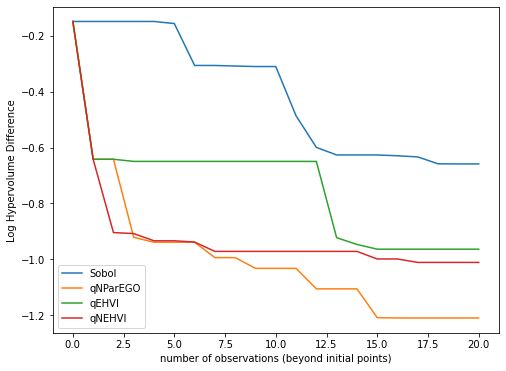

In [747]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline


iters = np.arange(N_BATCH + 1) * BATCH_SIZE
log_hv_difference_qparego = np.log10(problem.max_hv - np.asarray(hvs_qparego))
log_hv_difference_qehvi = np.log10(problem.max_hv - np.asarray(hvs_qehvi))
log_hv_difference_qnehvi = np.log10(problem.max_hv - np.asarray(hvs_qnehvi))
log_hv_difference_rnd = np.log10(problem.max_hv - np.asarray(hvs_random))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(
    iters, log_hv_difference_rnd, label="Sobol", linewidth=1.5,
)
ax.errorbar(
    iters, log_hv_difference_qparego, label="qNParEGO", linewidth=1.5,
)
ax.errorbar(
    iters, log_hv_difference_qehvi, label="qEHVI", linewidth=1.5,
)
ax.errorbar(
    iters, log_hv_difference_qnehvi, label="qNEHVI", linewidth=1.5,
)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='Log Hypervolume Difference')
ax.legend(loc="lower left")

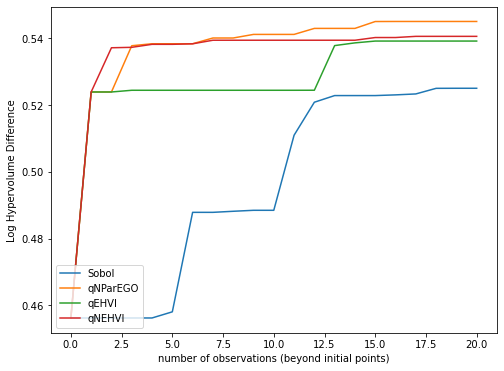

In [748]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline


iters = np.arange(N_BATCH + 1) * BATCH_SIZE
log_hv_difference_qparego = np.log10(np.asarray(hvs_qparego))
log_hv_difference_qehvi = np.log10(np.asarray(hvs_qehvi))
log_hv_difference_qnehvi = np.log10(np.asarray(hvs_qnehvi))
log_hv_difference_rnd = np.log10(np.asarray(hvs_random))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(
    iters, log_hv_difference_rnd, label="Sobol", linewidth=1.5,
)
ax.errorbar(
    iters, log_hv_difference_qparego, label="qNParEGO", linewidth=1.5,
)
ax.errorbar(
    iters, log_hv_difference_qehvi, label="qEHVI", linewidth=1.5,
)
ax.errorbar(
    iters, log_hv_difference_qnehvi, label="qNEHVI", linewidth=1.5,
)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='Log Hypervolume Difference')
ax.legend(loc="lower left")

#### Plot the true objectives at the evaluated designs colored by iteration

To examine optimization process from another perspective, we plot the true function values at the designs selected under each algorithm where the color corresponds to the BO iteration at which the point was collected. The plot on the right for $q$NEHVI shows that the $q$NEHVI quickly identifies the pareto front and most of its evaluations are very close to the pareto front. $q$NParEGO also identifies has many observations close to the pareto front, but relies on optimizing random scalarizations, which is a less principled way of optimizing the pareto front compared to $q$NEHVI, which explicitly attempts focuses on improving the pareto front. $q$EHVI uses the posterior mean as a plug-in estimator for the true function values at the in-sample points, whereas $q$NEHVI than integrating over the uncertainty at the in-sample designs Sobol generates random points and has few points close to the Pareto front.

Text(0.5, 1.0, 'Iteration')

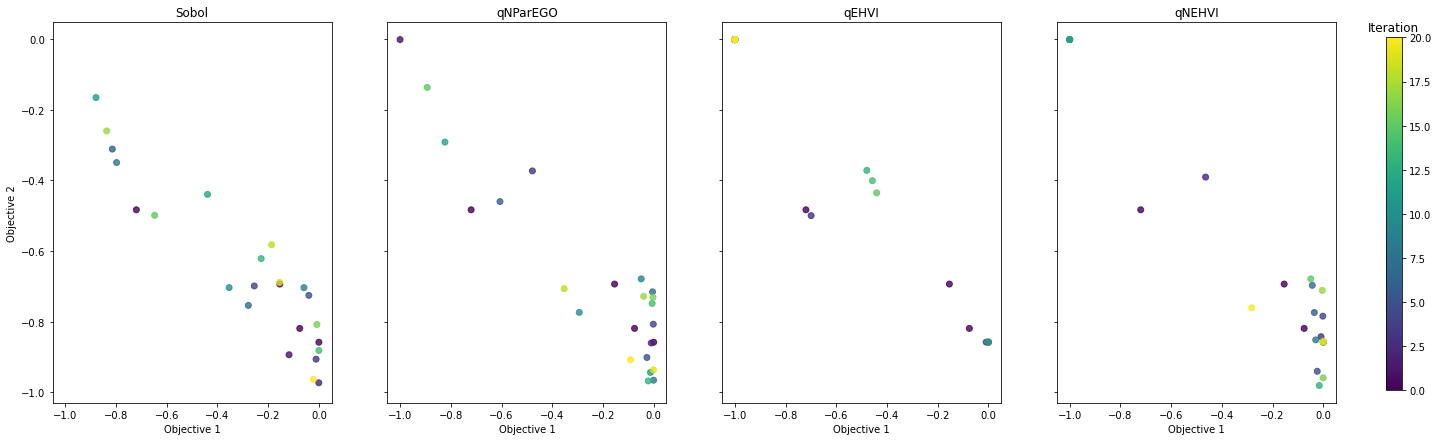

In [750]:
from matplotlib.cm import ScalarMappable


fig, axes = plt.subplots(1, 4, figsize=(23, 7), sharex=True, sharey=True)
algos = ["Sobol", "qNParEGO", "qEHVI", "qNEHVI"]
cm = plt.cm.get_cmap('viridis')

batch_number = torch.cat(
    [torch.zeros(2*(problem.dim+1)), torch.arange(1, N_BATCH+1).repeat(BATCH_SIZE, 1).t().reshape(-1)]
).numpy()
for i, train_obj in enumerate((train_obj_true_random, train_obj_true_qparego, train_obj_true_qehvi, train_obj_true_qnehvi)):
    sc = axes[i].scatter(
        train_obj[:, 0].cpu().numpy(), train_obj[:,1].cpu().numpy(), c=batch_number, alpha=0.8,
    )
    axes[i].set_title(algos[i])
    axes[i].set_xlabel("Objective 1")
axes[0].set_ylabel("Objective 2")
norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration")